# Deep Learning
## Deep Domain Adaptation - Office31 - Amazon to Webcam

**Name:** Margonis Phevos          
**ID:** f3352317                
**Date:** June, 2024

---

## Table of Contents
1. [Introduction](#introduction)
1. [No Adaptation (Baseline)](#baseline-1---no-adaptation)
2. [Train on Target (Baseline)](#baseline-2---train-on-target)
3. [Domain-Adversarial Neural Network (DANN)](#domain-adversarial-neural-network-dann)
5. [Results](#results)

---

## Introduction

Deep domain adaptation from Amazon to Webcam involves transferring learned representations from the Office 31 (Amazon) dataset to the Office 31 (Webcam) dataset. This task is challenging due to the significant differences in image characteristics between the two datasets. Two common baselines for evaluating domain adaptation performance are "No Adaptation," where a model trained on Amazon is directly tested on Webcam without any adaptation, and "Train on Test," where a model is trained and tested on the same target domain (Webcam). These baselines provide benchmarks to assess the effectiveness of domain adaptation techniques.

The Domain-Adversarial Neural Network (DANN) algorithm uses adversarial training to learn domain-invariant features, enhancing cross-domain performance. Applied to Amazon to Webcam adaptation, DANN aligns feature distributions using a gradient reversal layer, significantly improving digit classification accuracy. This method surpasses the NA baseline by effectively bridging the visual domain gap.

### Office-31 Dataset

<img src=".img/office31.jpg" alt="description" width="600" height="300">

The Office dataset contains 31 object categories in three domains: Amazon, DSLR and Webcam. The 31 categories in the dataset consist of objects commonly encountered in office settings, such as keyboards, file cabinets, and laptops. The Amazon domain contains on average 90 images per class and 2817 images in total. As these images were captured from a website of online merchants, they are captured against clean background and at a unified scale. The DSLR domain contains 498 low-noise high resolution images (4288×2848). There are 5 objects per category. Each object was captured from different viewpoints on average 3 times. For Webcam, the 795 images of low resolution (640×480) exhibit significant noise and color as well as white balance artifacts.

Source: [https://paperswithcode.com/dataset/office-31](https://paperswithcode.com/dataset/office-31)

---

## Baseline 1 - No Adaptation

In [ ]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, models, transforms

data = Path('data')
best_model_path = Path(".models/best_resnet50_NA.pth")

In [ ]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Import Office-31 Dataset

In [ ]:
dataset = datasets.ImageFolder(root=data/'office31'/'amazon'/'images')

In [ ]:
dataset, dataset.class_to_idx

(Dataset ImageFolder
     Number of datapoints: 2817
     Root location: data\office31\amazon\images,
 {'back_pack': 0,
  'bike': 1,
  'bike_helmet': 2,
  'bookcase': 3,
  'bottle': 4,
  'calculator': 5,
  'desk_chair': 6,
  'desk_lamp': 7,
  'desktop_computer': 8,
  'file_cabinet': 9,
  'headphones': 10,
  'keyboard': 11,
  'laptop_computer': 12,
  'letter_tray': 13,
  'mobile_phone': 14,
  'monitor': 15,
  'mouse': 16,
  'mug': 17,
  'paper_notebook': 18,
  'pen': 19,
  'phone': 20,
  'printer': 21,
  'projector': 22,
  'punchers': 23,
  'ring_binder': 24,
  'ruler': 25,
  'scissors': 26,
  'speaker': 27,
  'stapler': 28,
  'tape_dispenser': 29,
  'trash_can': 30})

In [ ]:
def create_data_loaders(data_dir, train_ratio=0.8, batch_size=32):
    # Define transforms
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Load dataset
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Define the train-test split ratio
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size

    # Create random train-test split
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

# Load DataLoaders
source_train_loader, source_test_loader = create_data_loaders(data_dir=data/'office31'/'amazon'/'images')
target_train_loader, target_test_loader = create_data_loaders(data_dir=data/'office31'/'webcam'/'images')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


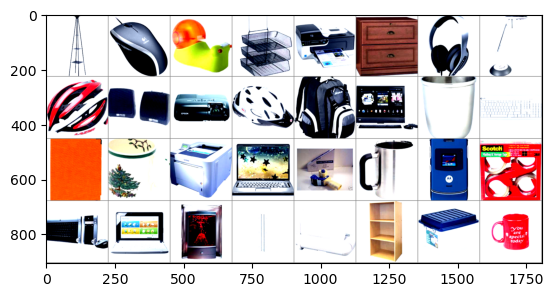

In [ ]:
# Visualize some images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
images, labels = next(iter(source_test_loader ))

# Show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
images.shape, len(labels)

(torch.Size([32, 3, 224, 224]), 32)

### Load and modify a pretrained ResNet50

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # load the latest weights

# modify the last layer
num_ftrs = model.fc.in_features # Gets the number of inputs for the last layer
model.fc = nn.Linear(num_ftrs, len(dataset.classes)) # Replaces the last layer


### Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training batch", leave=False)):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'====> Epoch: {epoch} Average train loss: {average_loss:.4f}')

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    average_val_loss = val_loss / len(val_loader)
    return average_val_loss

# Early stopping parameters
best_val_loss = float('inf')
best_epoch = -1
patience = 10
counter = 0

# Training loop with early stopping
for epoch in range(1, 101):
    train(model, source_train_loader, optimizer, criterion, epoch)
    val_loss = validate(model, source_test_loader, criterion)
    val_losses.append(val_loss)
    print(f'====> Epoch: {epoch} Validation loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
    
    # Early stopping
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break



Training batch:  99%|█████████▊| 70/71 [00:41<00:00,  1.74it/s]c:\Users\Foivos\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


====> Epoch: 1 Average train loss: 3.2097
====> Epoch: 1 Validation loss: 2.8829


====> Epoch: 2 Average train loss: 2.2999
====> Epoch: 2 Validation loss: 1.7652


====> Epoch: 3 Average train loss: 1.3039
====> Epoch: 3 Validation loss: 1.0415


====> Epoch: 4 Average train loss: 0.8383
====> Epoch: 4 Validation loss: 0.7919


====> Epoch: 5 Average train loss: 0.6115
====> Epoch: 5 Validation loss: 0.6935


====> Epoch: 6 Average train loss: 0.4813
====> Epoch: 6 Validation loss: 0.6386


====> Epoch: 7 Average train loss: 0.3992
====> Epoch: 7 Validation loss: 0.5800


====> Epoch: 8 Average train loss: 0.3267
====> Epoch: 8 Validation loss: 0.5468


====> Epoch: 9 Average train loss: 0.2575
====> Epoch: 9 Validation loss: 0.5475


====> Epoch: 10 Average train loss: 0.2228
====> Epoch: 10 Validation loss: 0.5143


====> Epoch: 11 Average train loss: 0.1802
====> Epoch: 11 Validation loss: 0.4974


====> Epoch: 12 Average train loss: 0.1563
====> Epoch: 12 Validation loss: 0.5030


====> Epoch: 13 Average train loss: 0.1308
====> Epoch: 13 Validation loss: 0.4905


====> Epoch: 14 Average train loss: 0.1104
====> Epoch: 14 Validation loss: 0.4957


====> Epoch: 15 Average train loss: 0.0979
====> Epoch: 15 Validation loss: 0.4899


====> Epoch: 16 Average train loss: 0.0871
====> Epoch: 16 Validation loss: 0.4719


====> Epoch: 17 Average train loss: 0.0744
====> Epoch: 17 Validation loss: 0.4752


====> Epoch: 18 Average train loss: 0.0636
====> Epoch: 18 Validation loss: 0.4905


====> Epoch: 19 Average train loss: 0.0553
====> Epoch: 19 Validation loss: 0.4821


====> Epoch: 20 Average train loss: 0.0536
====> Epoch: 20 Validation loss: 0.4720


====> Epoch: 21 Average train loss: 0.0450
====> Epoch: 21 Validation loss: 0.4791


====> Epoch: 22 Average train loss: 0.0393
====> Epoch: 22 Validation loss: 0.4766


====> Epoch: 23 Average train loss: 0.0390
====> Epoch: 23 Validation loss: 0.4743


====> Epoch: 24 Average train loss: 0.0339
====> Epoch: 24 Validation loss: 0.4918


====> Epoch: 25 Average train loss: 0.0311
====> Epoch: 25 Validation loss: 0.4917


====> Epoch: 26 Average train loss: 0.0299
====> Epoch: 26 Validation loss: 0.4741
Early stopping at epoch 26


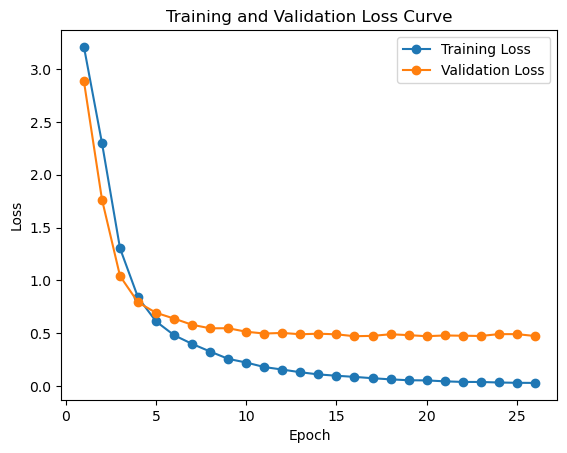

The best epoch is 16 with a validation loss of 0.4719


In [ ]:

# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

print(f'The best epoch is {best_epoch} with a validation loss of {best_val_loss:.4f}')


In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')


### Test with *optimal* model

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load(best_model_path))

# Evaluate
print(" Evaluate model on source_test: ")
test(model, source_test_loader, criterion)

print("No-Adaptation results: ")
test(model, target_test_loader, criterion)

 Evaluate model on source_test: 

Test set: Average loss: 0.4752, Accuracy: 500/564 (89%)

No-Adaptation results: 

Test set: Average loss: 0.7883, Accuracy: 128/159 (81%)



### Test on the complete target set
The target dataset is too small to discern any improvement, so we have to test on the train and test portions of the target set.

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
targ_dataset = datasets.ImageFolder(root=data/'office31'/'webcam'/'images', transform=transform)
targ_loader = DataLoader(targ_dataset, batch_size=32, shuffle=True)

In [ ]:
test(model, targ_loader, criterion)


Test set: Average loss: 0.8478, Accuracy: 592/795 (74%)



---



## Baseline 2 - Train on Target

In [ ]:
best_model_path = Path(".models/best_resnet50_ToT.pth") # CHANGE MEEEEEEE!!!!!

### Load and modify a pretrained ResNet50

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # load the latest weights

# modify the last layer
num_ftrs = model.fc.in_features # Gets the number of inputs for the last layer
model.fc = nn.Linear(num_ftrs, len(dataset.classes)) # Replaces the last layer


### Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training batch", leave=False)):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'====> Epoch: {epoch} Average train loss: {average_loss:.4f}')

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    average_val_loss = val_loss / len(val_loader)
    return average_val_loss

# Early stopping parameters
best_val_loss = float('inf')
best_epoch = -1
patience = 10
counter = 0

# Training loop with early stopping
for epoch in range(1, 101):
    train(model, target_train_loader, optimizer, criterion, epoch)
    val_loss = validate(model, target_test_loader, criterion)
    val_losses.append(val_loss)
    print(f'====> Epoch: {epoch} Validation loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
    
    # Early stopping
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break



====> Epoch: 1 Average train loss: 3.3810
====> Epoch: 1 Validation loss: 3.2822


====> Epoch: 2 Average train loss: 3.1358
====> Epoch: 2 Validation loss: 3.0304


====> Epoch: 3 Average train loss: 2.8266
====> Epoch: 3 Validation loss: 2.7243


====> Epoch: 4 Average train loss: 2.4399
====> Epoch: 4 Validation loss: 2.3495


====> Epoch: 5 Average train loss: 1.9973
====> Epoch: 5 Validation loss: 1.9044


====> Epoch: 6 Average train loss: 1.5404
====> Epoch: 6 Validation loss: 1.4432


====> Epoch: 7 Average train loss: 1.1273
====> Epoch: 7 Validation loss: 1.0656


====> Epoch: 8 Average train loss: 0.8065
====> Epoch: 8 Validation loss: 0.7919


====> Epoch: 9 Average train loss: 0.5439
====> Epoch: 9 Validation loss: 0.5744


====> Epoch: 10 Average train loss: 0.3974
====> Epoch: 10 Validation loss: 0.4517


====> Epoch: 11 Average train loss: 0.2979
====> Epoch: 11 Validation loss: 0.3539


====> Epoch: 12 Average train loss: 0.2211
====> Epoch: 12 Validation loss: 0.2843


====> Epoch: 13 Average train loss: 0.1665
====> Epoch: 13 Validation loss: 0.2505


====> Epoch: 14 Average train loss: 0.1449
====> Epoch: 14 Validation loss: 0.2172


====> Epoch: 15 Average train loss: 0.1217
====> Epoch: 15 Validation loss: 0.1866


====> Epoch: 16 Average train loss: 0.0950
====> Epoch: 16 Validation loss: 0.1635


====> Epoch: 17 Average train loss: 0.0865
====> Epoch: 17 Validation loss: 0.1560


====> Epoch: 18 Average train loss: 0.0781
====> Epoch: 18 Validation loss: 0.1417


====> Epoch: 19 Average train loss: 0.0698
====> Epoch: 19 Validation loss: 0.1290


====> Epoch: 20 Average train loss: 0.0587
====> Epoch: 20 Validation loss: 0.1210


====> Epoch: 21 Average train loss: 0.0626
====> Epoch: 21 Validation loss: 0.1142


====> Epoch: 22 Average train loss: 0.0518
====> Epoch: 22 Validation loss: 0.1111


====> Epoch: 23 Average train loss: 0.0486
====> Epoch: 23 Validation loss: 0.1008


====> Epoch: 24 Average train loss: 0.0450
====> Epoch: 24 Validation loss: 0.0983


====> Epoch: 25 Average train loss: 0.0383
====> Epoch: 25 Validation loss: 0.0926


====> Epoch: 26 Average train loss: 0.0392
====> Epoch: 26 Validation loss: 0.0840


====> Epoch: 27 Average train loss: 0.0325
====> Epoch: 27 Validation loss: 0.0852


====> Epoch: 28 Average train loss: 0.0355
====> Epoch: 28 Validation loss: 0.0772


====> Epoch: 29 Average train loss: 0.0349
====> Epoch: 29 Validation loss: 0.0808


====> Epoch: 30 Average train loss: 0.0300
====> Epoch: 30 Validation loss: 0.0733


====> Epoch: 31 Average train loss: 0.0287
====> Epoch: 31 Validation loss: 0.0689


====> Epoch: 32 Average train loss: 0.0257
====> Epoch: 32 Validation loss: 0.0695


====> Epoch: 33 Average train loss: 0.0288
====> Epoch: 33 Validation loss: 0.0667


====> Epoch: 34 Average train loss: 0.0269
====> Epoch: 34 Validation loss: 0.0675


====> Epoch: 35 Average train loss: 0.0264
====> Epoch: 35 Validation loss: 0.0643


====> Epoch: 36 Average train loss: 0.0205
====> Epoch: 36 Validation loss: 0.0593


====> Epoch: 37 Average train loss: 0.0203
====> Epoch: 37 Validation loss: 0.0614


====> Epoch: 38 Average train loss: 0.0199
====> Epoch: 38 Validation loss: 0.0560


====> Epoch: 39 Average train loss: 0.0205
====> Epoch: 39 Validation loss: 0.0591


====> Epoch: 40 Average train loss: 0.0201
====> Epoch: 40 Validation loss: 0.0560


====> Epoch: 41 Average train loss: 0.0176
====> Epoch: 41 Validation loss: 0.0546


====> Epoch: 42 Average train loss: 0.0187
====> Epoch: 42 Validation loss: 0.0546


====> Epoch: 43 Average train loss: 0.0152
====> Epoch: 43 Validation loss: 0.0511


====> Epoch: 44 Average train loss: 0.0161
====> Epoch: 44 Validation loss: 0.0501


====> Epoch: 45 Average train loss: 0.0145
====> Epoch: 45 Validation loss: 0.0503


====> Epoch: 46 Average train loss: 0.0158
====> Epoch: 46 Validation loss: 0.0476


====> Epoch: 47 Average train loss: 0.0157
====> Epoch: 47 Validation loss: 0.0496


====> Epoch: 48 Average train loss: 0.0153
====> Epoch: 48 Validation loss: 0.0478


====> Epoch: 49 Average train loss: 0.0142
====> Epoch: 49 Validation loss: 0.0481


====> Epoch: 50 Average train loss: 0.0115
====> Epoch: 50 Validation loss: 0.0467


====> Epoch: 51 Average train loss: 0.0134
====> Epoch: 51 Validation loss: 0.0455


====> Epoch: 52 Average train loss: 0.0113
====> Epoch: 52 Validation loss: 0.0463


====> Epoch: 53 Average train loss: 0.0155
====> Epoch: 53 Validation loss: 0.0440


====> Epoch: 54 Average train loss: 0.0132
====> Epoch: 54 Validation loss: 0.0438


====> Epoch: 55 Average train loss: 0.0117
====> Epoch: 55 Validation loss: 0.0449


====> Epoch: 56 Average train loss: 0.0114
====> Epoch: 56 Validation loss: 0.0415


====> Epoch: 57 Average train loss: 0.0103
====> Epoch: 57 Validation loss: 0.0430


====> Epoch: 58 Average train loss: 0.0111
====> Epoch: 58 Validation loss: 0.0435


====> Epoch: 59 Average train loss: 0.0105
====> Epoch: 59 Validation loss: 0.0433


====> Epoch: 60 Average train loss: 0.0107
====> Epoch: 60 Validation loss: 0.0417


====> Epoch: 61 Average train loss: 0.0102
====> Epoch: 61 Validation loss: 0.0436


====> Epoch: 62 Average train loss: 0.0094
====> Epoch: 62 Validation loss: 0.0426


====> Epoch: 63 Average train loss: 0.0108
====> Epoch: 63 Validation loss: 0.0393


====> Epoch: 64 Average train loss: 0.0097
====> Epoch: 64 Validation loss: 0.0403


====> Epoch: 65 Average train loss: 0.0088
====> Epoch: 65 Validation loss: 0.0390


====> Epoch: 66 Average train loss: 0.0087
====> Epoch: 66 Validation loss: 0.0378


====> Epoch: 67 Average train loss: 0.0079
====> Epoch: 67 Validation loss: 0.0396


====> Epoch: 68 Average train loss: 0.0089
====> Epoch: 68 Validation loss: 0.0379


====> Epoch: 69 Average train loss: 0.0077
====> Epoch: 69 Validation loss: 0.0367


====> Epoch: 70 Average train loss: 0.0084
====> Epoch: 70 Validation loss: 0.0349


====> Epoch: 71 Average train loss: 0.0093
====> Epoch: 71 Validation loss: 0.0394


====> Epoch: 72 Average train loss: 0.0095
====> Epoch: 72 Validation loss: 0.0391


====> Epoch: 73 Average train loss: 0.0087
====> Epoch: 73 Validation loss: 0.0399


====> Epoch: 74 Average train loss: 0.0085
====> Epoch: 74 Validation loss: 0.0394


====> Epoch: 75 Average train loss: 0.0071
====> Epoch: 75 Validation loss: 0.0378


====> Epoch: 76 Average train loss: 0.0076
====> Epoch: 76 Validation loss: 0.0383


====> Epoch: 77 Average train loss: 0.0068
====> Epoch: 77 Validation loss: 0.0349


====> Epoch: 78 Average train loss: 0.0062
====> Epoch: 78 Validation loss: 0.0343


====> Epoch: 79 Average train loss: 0.0060
====> Epoch: 79 Validation loss: 0.0378


====> Epoch: 80 Average train loss: 0.0066
====> Epoch: 80 Validation loss: 0.0348


====> Epoch: 81 Average train loss: 0.0071
====> Epoch: 81 Validation loss: 0.0347


====> Epoch: 82 Average train loss: 0.0061
====> Epoch: 82 Validation loss: 0.0365


====> Epoch: 83 Average train loss: 0.0067
====> Epoch: 83 Validation loss: 0.0334


====> Epoch: 84 Average train loss: 0.0061
====> Epoch: 84 Validation loss: 0.0360


====> Epoch: 85 Average train loss: 0.0065
====> Epoch: 85 Validation loss: 0.0364


====> Epoch: 86 Average train loss: 0.0061
====> Epoch: 86 Validation loss: 0.0341


====> Epoch: 87 Average train loss: 0.0069
====> Epoch: 87 Validation loss: 0.0327


====> Epoch: 88 Average train loss: 0.0067
====> Epoch: 88 Validation loss: 0.0350


====> Epoch: 89 Average train loss: 0.0047
====> Epoch: 89 Validation loss: 0.0328


====> Epoch: 90 Average train loss: 0.0062
====> Epoch: 90 Validation loss: 0.0336


====> Epoch: 91 Average train loss: 0.0055
====> Epoch: 91 Validation loss: 0.0326


====> Epoch: 92 Average train loss: 0.0071
====> Epoch: 92 Validation loss: 0.0347


====> Epoch: 93 Average train loss: 0.0051
====> Epoch: 93 Validation loss: 0.0332


====> Epoch: 94 Average train loss: 0.0060
====> Epoch: 94 Validation loss: 0.0339


====> Epoch: 95 Average train loss: 0.0053
====> Epoch: 95 Validation loss: 0.0328


====> Epoch: 96 Average train loss: 0.0056
====> Epoch: 96 Validation loss: 0.0319


====> Epoch: 97 Average train loss: 0.0053
====> Epoch: 97 Validation loss: 0.0339


====> Epoch: 98 Average train loss: 0.0084
====> Epoch: 98 Validation loss: 0.0334


====> Epoch: 99 Average train loss: 0.0053
====> Epoch: 99 Validation loss: 0.0313


====> Epoch: 100 Average train loss: 0.0069
====> Epoch: 100 Validation loss: 0.0326


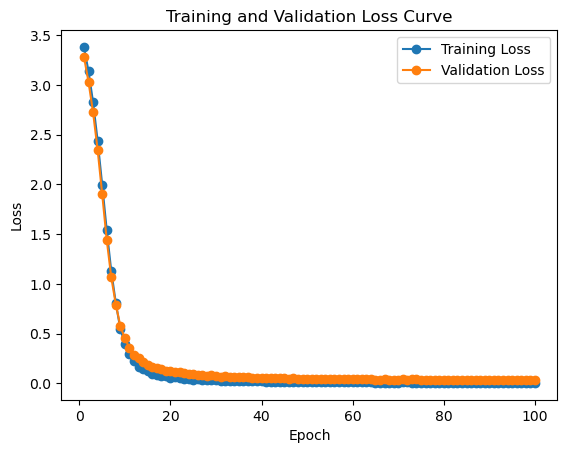

The best epoch is 99 with a validation loss of 0.0313


In [ ]:

# Plot the training and validation loss curves
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

print(f'The best epoch is {best_epoch} with a validation loss of {best_val_loss:.4f}')


In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')


### Test with *optimal* model

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load(best_model_path))

print(" Evaluate model on target_test: ")
test(model, target_test_loader, criterion)

 Evaluate model on target_test: 

Test set: Average loss: 0.0313, Accuracy: 158/159 (99%)



---



## Domain-Adversarial Neural Network (DANN)

In [ ]:
best_model_path = Path(".models/best_resnet50_DAN_SGD.pth") # CHANGE MEEEEEEE!!!!!

### Define the DANN Model

In [ ]:
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

# Load pretrained ResNet50
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Remove the last fully connected layer
        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()
        self.fc = nn.Linear(2048, 31)  # 2048 is the output size of ResNet50 features, 31 is the number of classes
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fc(x)
        return x

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.fc = nn.Linear(2048, 2)  # 2048 is the output size of ResNet50 features, 2 is for source and target domains
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, alpha):
        x = GradReverse.apply(x, alpha)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature_extractor = ResNet50FeatureExtractor()
        self.label_predictor = LabelPredictor()
        self.domain_classifier = DomainClassifier()

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        label_output = self.label_predictor(features)
        domain_output = self.domain_classifier(features, alpha)
        return label_output, domain_output

### Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store the losses
train_losses = []
val_losses = []
train_loss_label = []
train_loss_domain_s = []
train_loss_domain_t = []

def train(model, source_loader, target_loader, optimizer, criterion, epoch):
    model.train()
    len_dataloader = min(len(source_loader), len(target_loader))
    data_zip = enumerate(zip(source_loader, target_loader))
    epoch_loss = 0.0
    epoch_loss_label = 0.0
    epoch_loss_domain_s = 0.0
    epoch_loss_domain_t = 0.0
    
    for batch_idx, ((data_s, label_s), (data_t, _)) in tqdm(data_zip, total=len_dataloader, desc="Training batch", leave=False):
        data_s, label_s = data_s.to(device), label_s.to(device)
        data_t = data_t.to(device)

        optimizer.zero_grad()

        # Training the label predictor
        p = float(batch_idx + epoch * len_dataloader) / (10 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        label_output, domain_output_s = model(data_s, alpha=alpha)
        _, domain_output_t = model(data_t, alpha=alpha)

        loss_label = criterion(label_output, label_s)
        loss_domain_s = criterion(domain_output_s, torch.zeros(len(data_s), dtype=torch.long).to(device))
        loss_domain_t = criterion(domain_output_t, torch.ones(len(data_t), dtype=torch.long).to(device))

        loss = loss_label + loss_domain_s + loss_domain_t
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loss_label += loss_label.item()
        epoch_loss_domain_s += loss_domain_s.item()
        epoch_loss_domain_t += loss_domain_t.item()

    average_loss = epoch_loss / len_dataloader
    average_loss_label = epoch_loss_label / len_dataloader
    average_loss_domain_s = epoch_loss_domain_s / len_dataloader
    average_loss_domain_t = epoch_loss_domain_t / len_dataloader
    
    train_losses.append(average_loss)
    train_loss_label.append(average_loss_label)
    train_loss_domain_s.append(average_loss_domain_s)
    train_loss_domain_t.append(average_loss_domain_t)
    
    print(f'====> Epoch: {epoch} Average train loss: {average_loss:.4f}')
    # print(f'      Label loss: {average_loss_label:.4f}, Domain source loss: {average_loss_domain_s:.4f}, Domain target loss: {average_loss_domain_t:.4f}')

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            label_output, _ = model(data, alpha=0)  # alpha is not used during validation
            loss = criterion(label_output, label)
            val_loss += loss.item()
    
    average_val_loss = val_loss / len(val_loader)
    return average_val_loss

best_val_loss = float('inf')
best_epoch = -1
patience = 10
counter = 0

for epoch in range(1, 201):  # Increased number of epochs to account for early stopping
    train(model, source_train_loader, target_train_loader, optimizer, criterion, epoch)
    val_loss = validate(model, source_test_loader, criterion)
    val_losses.append(val_loss)
    print(f'====> Epoch: {epoch} Validation loss: {val_loss:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
    
    # Early stopping
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

====> Epoch: 1 Average train loss: 4.7976
====> Epoch: 1 Validation loss: 3.3522


====> Epoch: 2 Average train loss: 4.5755
====> Epoch: 2 Validation loss: 3.2031


====> Epoch: 3 Average train loss: 4.4088
====> Epoch: 3 Validation loss: 3.0524


====> Epoch: 4 Average train loss: 4.1478
====> Epoch: 4 Validation loss: 2.8417


====> Epoch: 5 Average train loss: 3.8864
====> Epoch: 5 Validation loss: 2.5923


====> Epoch: 6 Average train loss: 3.6197
====> Epoch: 6 Validation loss: 2.2961


====> Epoch: 7 Average train loss: 3.3183
====> Epoch: 7 Validation loss: 2.0202


====> Epoch: 8 Average train loss: 3.0554
====> Epoch: 8 Validation loss: 1.7343


====> Epoch: 9 Average train loss: 2.7895
====> Epoch: 9 Validation loss: 1.4894


====> Epoch: 10 Average train loss: 2.7184
====> Epoch: 10 Validation loss: 1.3360


====> Epoch: 11 Average train loss: 2.5506
====> Epoch: 11 Validation loss: 1.2115


====> Epoch: 12 Average train loss: 2.7177
====> Epoch: 12 Validation loss: 1.1340


====> Epoch: 13 Average train loss: 2.9244
====> Epoch: 13 Validation loss: 1.0944


====> Epoch: 14 Average train loss: 2.6970
====> Epoch: 14 Validation loss: 1.0657


====> Epoch: 15 Average train loss: 2.3876
====> Epoch: 15 Validation loss: 1.0023


====> Epoch: 16 Average train loss: 2.3226
====> Epoch: 16 Validation loss: 0.9098


====> Epoch: 17 Average train loss: 2.4262
====> Epoch: 17 Validation loss: 0.8344


====> Epoch: 18 Average train loss: 2.5381
====> Epoch: 18 Validation loss: 0.8519


====> Epoch: 19 Average train loss: 2.1726
====> Epoch: 19 Validation loss: 0.8087


====> Epoch: 20 Average train loss: 2.2054
====> Epoch: 20 Validation loss: 0.7807


====> Epoch: 21 Average train loss: 2.2866
====> Epoch: 21 Validation loss: 1.1275


====> Epoch: 22 Average train loss: 2.2143
====> Epoch: 22 Validation loss: 0.8283


====> Epoch: 23 Average train loss: 2.1614
====> Epoch: 23 Validation loss: 0.8050


====> Epoch: 24 Average train loss: 2.4968
====> Epoch: 24 Validation loss: 0.7217


====> Epoch: 25 Average train loss: 2.1844
====> Epoch: 25 Validation loss: 0.7628


====> Epoch: 26 Average train loss: 2.5225
====> Epoch: 26 Validation loss: 0.7451


====> Epoch: 27 Average train loss: 2.9163
====> Epoch: 27 Validation loss: 0.7680


====> Epoch: 28 Average train loss: 3.3325
====> Epoch: 28 Validation loss: 0.6927


====> Epoch: 29 Average train loss: 2.7780
====> Epoch: 29 Validation loss: 0.6815


====> Epoch: 30 Average train loss: 2.4770
====> Epoch: 30 Validation loss: 0.6523


====> Epoch: 31 Average train loss: 2.3022
====> Epoch: 31 Validation loss: 0.7087


====> Epoch: 32 Average train loss: 2.3259
====> Epoch: 32 Validation loss: 0.7123


====> Epoch: 33 Average train loss: 2.2454
====> Epoch: 33 Validation loss: 0.7385


====> Epoch: 34 Average train loss: 2.1268
====> Epoch: 34 Validation loss: 0.7364


====> Epoch: 35 Average train loss: 1.9497
====> Epoch: 35 Validation loss: 0.6985


====> Epoch: 36 Average train loss: 2.0664
====> Epoch: 36 Validation loss: 0.6879


====> Epoch: 37 Average train loss: 2.1816
====> Epoch: 37 Validation loss: 0.6670


====> Epoch: 38 Average train loss: 2.3308
====> Epoch: 38 Validation loss: 0.6424


====> Epoch: 39 Average train loss: 2.8813
====> Epoch: 39 Validation loss: 0.6584


====> Epoch: 40 Average train loss: 4.1721
====> Epoch: 40 Validation loss: 0.6938


====> Epoch: 41 Average train loss: 7.5835
====> Epoch: 41 Validation loss: 1.0967


====> Epoch: 42 Average train loss: 8.7960
====> Epoch: 42 Validation loss: 1.2321


====> Epoch: 43 Average train loss: 8.1071
====> Epoch: 43 Validation loss: 0.6756


====> Epoch: 44 Average train loss: 15.8744
====> Epoch: 44 Validation loss: 1.6378


====> Epoch: 45 Average train loss: 12.2628
====> Epoch: 45 Validation loss: 5.6191


====> Epoch: 46 Average train loss: 20.3785
====> Epoch: 46 Validation loss: 2.5912


====> Epoch: 47 Average train loss: 14.5509
====> Epoch: 47 Validation loss: 1.6721


====> Epoch: 48 Average train loss: 17.4273
====> Epoch: 48 Validation loss: 1.8739
Early stopping at epoch 48


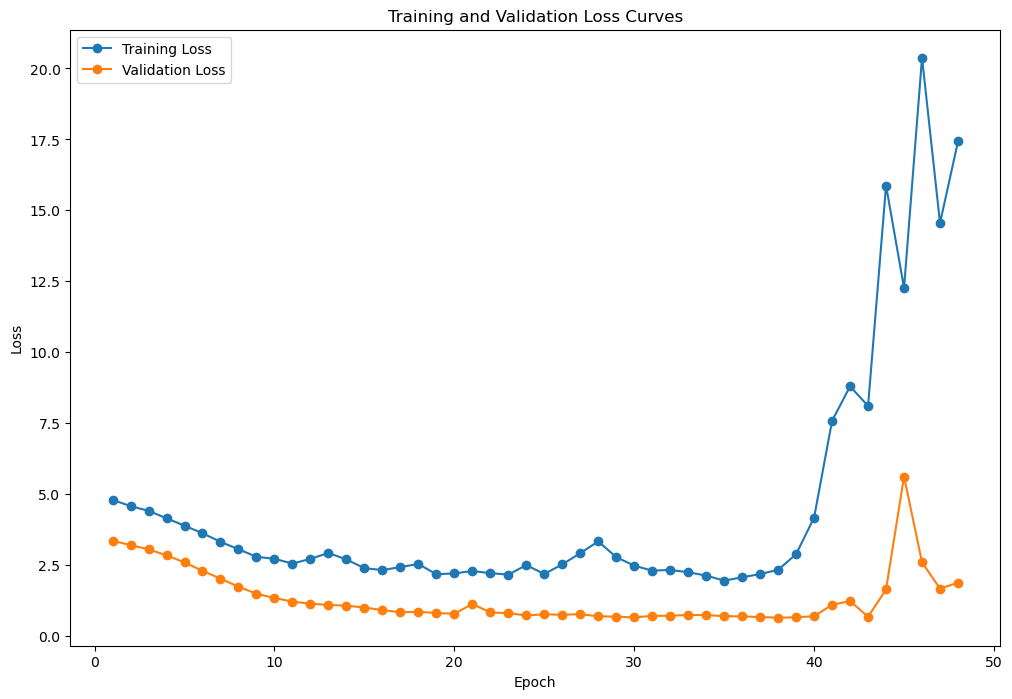

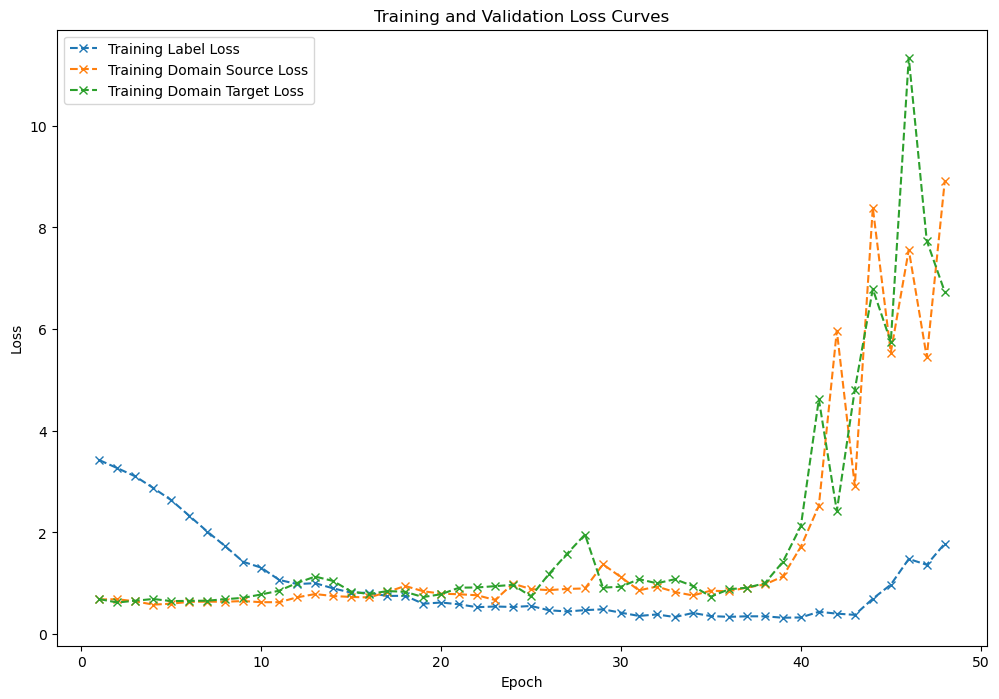

The best epoch is 38 with a validation loss of 0.6424


In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.figure(figsize=(12, 8))

# Overall training loss
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Individual training losses
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(train_loss_label) + 1), train_loss_label, marker='x', linestyle='--', label='Training Label Loss')
plt.plot(range(1, len(train_loss_domain_s) + 1), train_loss_domain_s, marker='x', linestyle='--', label='Training Domain Source Loss')
plt.plot(range(1, len(train_loss_domain_t) + 1), train_loss_domain_t, marker='x', linestyle='--', label='Training Domain Target Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

print(f'The best epoch is {best_epoch} with a validation loss of {best_val_loss:.4f}')



### Test

In [ ]:
def test(model, target_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in target_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(target_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(target_loader.dataset)} '
          f'({100. * correct / len(target_loader.dataset):.0f}%)\n')

### Test with *optimal* model

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load(best_model_path))

test(model, target_test_loader, criterion)


Test set: Average loss: 0.0233, Accuracy: 129/159 (81%)



### Test on the complete target set
The target dataset is too small to discern any improvement, so we have to test on the train and test portions of the target set.

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
targ_dataset = datasets.ImageFolder(root=data/'office31'/'webcam'/'images', transform=transform)
targ_loader = DataLoader(targ_dataset, batch_size=32, shuffle=True)

In [ ]:
test(model, targ_loader, criterion)


Test set: Average loss: 0.0236, Accuracy: 637/795 (80%)



## Results

Method|Accuracy on Target Domain
---|---
No Adaptation|74%
**DANN**|**80%**
Train on Target|99%